In [2]:
# Importing necessary libraries to unzip `tiny-imagenet-200.zip`
import os
import zipfile

# Unzip the dataset
with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
# Lets see the directory structure of tiny-imagenet-200
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        jpeg_files = [f for f in files if f.endswith('.JPEG')]
        if jpeg_files:  # if the list is not empty
            print('{}Number of JPEG files: {}'.format(subindent, len(jpeg_files)))
        for f in files:
            if f.endswith('.txt'):
                print('{}{}'.format(subindent, f))

list_files('tiny-imagenet-200')

tiny-imagenet-200/
    wnids.txt
    words.txt
    test/
        images/
            Number of JPEG files: 10000
    train/
        n02795169/
            n02795169_boxes.txt
            images/
                Number of JPEG files: 500
        n02769748/
            n02769748_boxes.txt
            images/
                Number of JPEG files: 500
        n07920052/
            n07920052_boxes.txt
            images/
                Number of JPEG files: 500
        n02917067/
            n02917067_boxes.txt
            images/
                Number of JPEG files: 500
        n01629819/
            n01629819_boxes.txt
            images/
                Number of JPEG files: 500
        n02058221/
            n02058221_boxes.txt
            images/
                Number of JPEG files: 500
        n02793495/
            n02793495_boxes.txt
            images/
                Number of JPEG files: 500
        n04251144/
            n04251144_boxes.txt
            images/
              

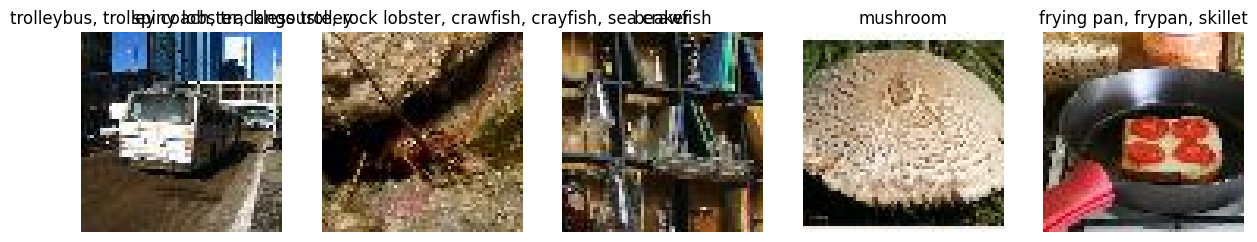

In [5]:
# Required Libraries
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Path and Files
path = './tiny-imagenet-200/train/'
wnid_labels = dict(line.strip().split('\t') for line in open('./tiny-imagenet-200/words.txt'))  # Corrected path
dirs = os.listdir(path)

# Sample 5 random images from the train directory
samples = []
for _ in range(5):
    random_dir = random.choice(dirs)
    random_image = random.choice(os.listdir(os.path.join(path, random_dir, 'images')))
    samples.append((random_dir, os.path.join(path, random_dir, 'images', random_image)))

# Display the sampled images with their English wnid representations
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, (wnid, img_path) in enumerate(samples):
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].title.set_text(wnid_labels[wnid])
    axs[i].axis('off')

plt.show()